In [2]:
import MySQLdb as db
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

# Analytics Base Table

Dataframe contianing all data needed for modelling

In [3]:
# Read in csv containing ABT
name = 'DatabaseMain'
conn = db.connect(host = "localhost", user = "root", passwd ="", db=name)
cursor = conn.cursor()

sql = ''' SELECT G.DateTime, W.Room, R.Capacity, T.Module, M.NumReg, W.Associated, G.PercentageEstimate, G.BinaryEstimate
          FROM DatabaseMain.WiFiLogData W, DatabaseMain.GroundTruth G, DatabaseMain.Rooms R, DatabaseMain.TimeModule T,
          DatabaseMain.Modules M
          WHERE W.Room = G.Room AND W.DateTime BETWEEN G.DateTime AND DATE_ADD(G.DateTime, INTERVAL 1 HOUR) 
          AND R.Room = W.Room AND R.Room = G.Room AND T.Room = G.Room AND T.Room = R.Room AND T.Room =  W.Room 
          AND T.DateTime = G.DateTime AND M.ModuleName = T.Module
          ORDER BY G.DateTime'''
df = pd.read_sql_query(sql, conn)
df.head()


,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate
0,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,125,0.75,1
1,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,130,0.75,1
2,2015-11-03 09:00:00,B-002,90,None,0,2,0.00,0
3,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,68,0.75,1
4,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0


In [64]:
df.head()

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate
0,2015-11-03 09:00:00,B-002,90,None,0,4,0.0,0
1,2015-11-03 09:00:00,B-002,90,None,0,21,0.0,0
2,2015-11-03 09:00:00,B-003,90,None,0,1,0.0,0
3,2015-11-03 09:00:00,B-003,90,None,0,2,0.0,0
4,2015-11-03 09:00:00,B-003,90,None,0,2,0.0,0


In [5]:
df.dtypes

DateTime              datetime64[ns]
Room                          object
Capacity                       int64
Module                        object
NumReg                         int64
Associated                     int64
PercentageEstimate           float64
BinaryEstimate                 int64
dtype: object

In [6]:
df['Room'] = df['Room'].astype('category')
df['Module'] = df['Module'].astype('category')
df['DateTime'] = df['DateTime'].astype('category')
df.dtypes

DateTime              category
Room                  category
Capacity                 int64
Module                category
NumReg                   int64
Associated               int64
PercentageEstimate     float64
BinaryEstimate           int64
dtype: object

In [7]:
df.corr()

,Capacity,NumReg,Associated,PercentageEstimate,BinaryEstimate
Capacity,1.000000,0.463803,0.307442,-0.043771,-0.059141
NumReg,0.463803,1.000000,0.672959,0.348959,0.290459
Associated,0.307442,0.672959,1.000000,0.561168,0.429123
PercentageEstimate,-0.043771,0.348959,0.561168,1.000000,0.770780
BinaryEstimate,-0.059141,0.290459,0.429123,0.770780,1.000000


## MODEL 2 - TARGET FEATURE EstimateNumPeople - HOW MANY PEOPLE IN THE ROOM?

Find how many people are in the room:
    EstimateNumPeople = Room capacity x percentage estimate {1}

This models predicts the number of people in the room but the predicted results are also used to find the predicted percentage of people in the room.

To find the percentage of people in the room the predictions (continuous values as this is a linear model) are divided by the capacity of the room (reverse of equation {1}). This will give us a percentage of people in the room. This percentage is then binned into the appropriate category (0.0, 0.25, 0.5, 0.75 or 1.0).

In [8]:
# add a column to the dataframe containing the estimate of the number of people in the room
df['EstimateNumPeople'] = df['Capacity'] * df['PercentageEstimate']
df.head()

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,EstimateNumPeople
0,2015-11-03 09:00:00,B-002,90,None,0,0,0.00,0,0.0
1,2015-11-03 09:00:00,B-002,90,None,0,2,0.00,0,0.0
2,2015-11-03 09:00:00,B-002,90,None,0,4,0.00,0,0.0
3,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,62,0.75,1,165.0
4,2015-11-03 09:00:00,B-002,90,None,0,21,0.00,0,0.0


## Understanding data

In [9]:
# Look at correlations for all the continuous features.
df[['Capacity', 'NumReg', 'Associated', 'EstimateNumPeople']].corr()

,Capacity,NumReg,Associated,EstimateNumPeople
Capacity,1.000000,0.463803,0.307442,0.391415
NumReg,0.463803,1.000000,0.672959,0.563652
Associated,0.307442,0.672959,1.000000,0.697991
EstimateNumPeople,0.391415,0.563652,0.697991,1.000000


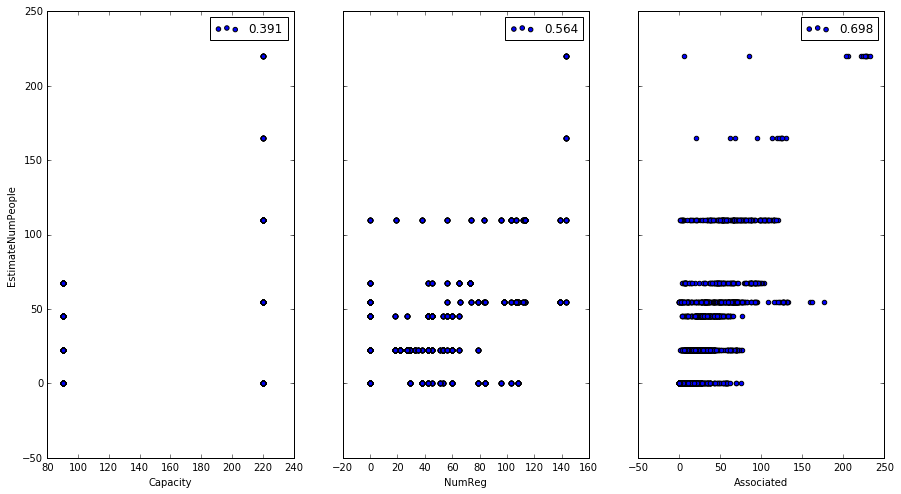

In [10]:
# Scatterplots for each descriptive feature and target feature. 
# Show the correlation value in the plot.
fig, axs = plt.subplots(1, 3, sharey = True)
df.plot(kind='scatter', x = 'Capacity', y = 'EstimateNumPeople', label="%.3f" % df[['Capacity', 'EstimateNumPeople']].corr().as_matrix()[0,1], ax = axs[0])
df.plot(kind='scatter', x = 'NumReg', y = 'EstimateNumPeople', label="%.3f" % df[['NumReg', 'EstimateNumPeople']].corr().as_matrix()[0,1], ax = axs[1])
df.plot(kind='scatter', x = 'Associated', y = 'EstimateNumPeople', label="%.3f" % df[['Associated', 'EstimateNumPeople']].corr().as_matrix()[0,1], ax = axs[2], figsize =(15,8))

# Linear regression with package statsmodel

## Multiple linear regression
### Training a model

In [11]:
#Import statsmodels package for training a linear regression model.
import statsmodels.formula.api as sm

# Train aka fit, a model using all features
lm = sm.ols(formula="EstimateNumPeople ~  Capacity + NumReg + Associated + C(Room) -1 + C(DateTime)-1 + C(Module)-1", data=df).fit()

# Print the weights learned for each feature.
print(lm.params)

C(Room)[B-002]                                     -5.569301
C(Room)[B-003]                                      3.910821
C(Room)[B-004]                                      0.678609
C(DateTime)[T.Timestamp('2015-11-03 10:00:00')]    36.452584
C(DateTime)[T.Timestamp('2015-11-03 11:00:00')]    41.217585
C(DateTime)[T.Timestamp('2015-11-03 12:00:00')]    24.756026
C(DateTime)[T.Timestamp('2015-11-03 13:00:00')]    13.269949
C(DateTime)[T.Timestamp('2015-11-03 14:00:00')]    15.012607
C(DateTime)[T.Timestamp('2015-11-03 15:00:00')]     3.037836
C(DateTime)[T.Timestamp('2015-11-03 16:00:00')]   -16.678071
C(DateTime)[T.Timestamp('2015-11-04 09:00:00')]    38.791821
C(DateTime)[T.Timestamp('2015-11-04 10:00:00')]    -3.330942
C(DateTime)[T.Timestamp('2015-11-04 11:00:00')]    -1.070620
C(DateTime)[T.Timestamp('2015-11-04 12:00:00')]    -2.147100
C(DateTime)[T.Timestamp('2015-11-04 13:00:00')]   -22.057415
C(DateTime)[T.Timestamp('2015-11-04 14:00:00')]   -20.086372
C(DateTime)[T.Timestamp(

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d1885e588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d18682e80>]], dtype=object)

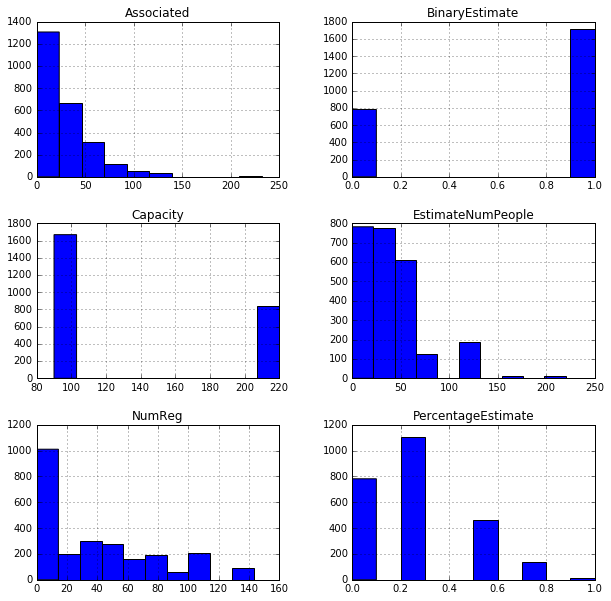

In [14]:
df.hist(figsize = (10,10))

/home/ellen/anaconda3/envs/research/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x7f2d18054630>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2d1805cfd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2d17fe8978>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2d18062a20>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2d18054f60>,
  <matplotlib.lines.Line2D at 0x7f2d17fb9ef0>]}

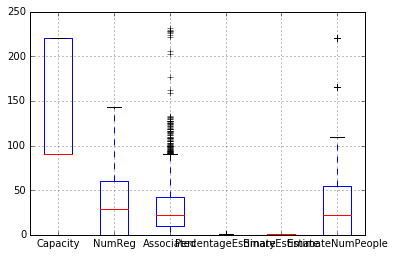

In [20]:
df.boxplot(figsize = (30,30))

In [51]:
#estimate = df['EstimateNumPeople']
# stackoverflow.com/questions/32973847/removing-known-outliers-from-pandas-dataframe
#df = df[~(df.EstimateNumPeople>200)]
# df.loc[549:585]
# df.loc[3:35]



,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,EstimateNumPeople


In [52]:
# Print the summary of the trained model.
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      EstimateNumPeople   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     80.73
Date:                Fri, 29 Jul 2016   Prob (F-statistic):               0.00
Time:                        13:31:01   Log-Likelihood:                -10333.
No. Observations:                2502   AIC:                         2.092e+04
Df Residuals:                    2374   BIC:                         2.167e+04
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

### Evaluating the model on training and test data
Split the dataset into a training set and a test set. Fit the model on the training set, evaluate both on the training and the test set. Compare the prediction error on both sets.

In [53]:
# Take the first 3/4 as training data
print(len(df))
df_train = df[:2000]
df_train.head()
print(len(df_train))

2490
2000


In [54]:
# Take the last 1/4 rows as test data
df_test = df[2000:].reset_index(drop=True)
df_test.head()
print(len(df_test))

490


In [55]:
# mix up rows
# df = df.iloc[np.random.permutation(len(df))].reset_index(drop=True)
# split into training and test
# from sklearn.cross_validation import train_test_split
# df_train, df_test = train_test_split(df, test_size = 0.2)

## Training on df_train

In [56]:
# Train aka fit, a model using all features.
lm = sm.ols(formula="EstimateNumPeople ~  Capacity + NumReg + Associated + C(Room) -1 + C(DateTime) -1 + C(Module)-1", data=df_train).fit()

# Print the weights learned for each feature.
print(lm.params)

C(Room)[B-002]                                      4.503007
C(Room)[B-003]                                      1.314132
C(Room)[B-004]                                     -2.379701
C(DateTime)[T.Timestamp('2015-11-03 10:00:00')]    37.616885
C(DateTime)[T.Timestamp('2015-11-03 11:00:00')]    27.230576
C(DateTime)[T.Timestamp('2015-11-03 12:00:00')]    25.413639
C(DateTime)[T.Timestamp('2015-11-03 13:00:00')]    -7.514213
C(DateTime)[T.Timestamp('2015-11-03 14:00:00')]    14.650689
C(DateTime)[T.Timestamp('2015-11-03 15:00:00')]    -1.722305
C(DateTime)[T.Timestamp('2015-11-03 16:00:00')]   -13.864220
C(DateTime)[T.Timestamp('2015-11-04 09:00:00')]    43.295977
C(DateTime)[T.Timestamp('2015-11-04 10:00:00')]     0.624389
C(DateTime)[T.Timestamp('2015-11-04 11:00:00')]     1.388922
C(DateTime)[T.Timestamp('2015-11-04 12:00:00')]     2.199417
C(DateTime)[T.Timestamp('2015-11-04 13:00:00')]   -17.385402
C(DateTime)[T.Timestamp('2015-11-04 14:00:00')]   -13.545141
C(DateTime)[T.Timestamp(

In [57]:
# Print the detailed metrics for the trained model.
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      EstimateNumPeople   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     99.82
Date:                Fri, 29 Jul 2016   Prob (F-statistic):               0.00
Time:                        13:31:15   Log-Likelihood:                -7824.3
No. Observations:                2000   AIC:                         1.588e+04
Df Residuals:                    1885   BIC:                         1.652e+04
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

## Testing on df_train

In [58]:
# test on df_train
lm.predict(df_train)

array([ 16.61577213,  17.09233597,  17.56889981, ...,  26.57213292,
        23.95103179,  23.71274987])

In [59]:
# PREDICTIONS (TRAINING) : ESTIMATE OF NUMBER OF PEOPLE
predictions_train = lm.predict(df_train)

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_train.EstimateNumPeople), predictions_train)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       0.0     16.61577213079323
1       0.0     17.092335971576247
2       0.0     17.568899812359266
3       165.0   123.61908250625567
4       0.0     21.619692459014935
5       165.0   137.2011519685717
6       0.0     13.665179238043441
7       165.0   138.39256157052927
8       0.0     13.90346115843495
9       165.0   139.82225309287833
10      0.0     13.90346115843495
11      0.0     15.571434601175518
12      0.0     17.092335971576247
13      0.0     16.61577213079323
14      0.0     16.85405405118474
15      0.0     17.33061789196776
16      165.0   131.4823858791755
17      0.0     13.90346115843495
18      165.0   138.39256157052927
19      0.0     13.665179238043441
20      165.0   138.63084349092077
21      0.0     14.14174307882646
22      165.0   125.04877402860473
23      0.0     13.665179238043441
24      0.0     16.85405405118474
25      0.0     16.85405405118474
26      0.0     17.568899812359266
27      0.0     20.904846697840405
28    

# Accuracy score of EstimateNumPeople - Training data

In [60]:
# EstimateNumPeople has certain set of values
myList = [0.0, 67.5, 165.0, 45.0, 110.0, 22.5, 55.0, 220.0, 90.0]
#myList = set(df_train.EstimateNumPeople)

# http://stackoverflow.com/questions/12141150/from-list-of-integers-get-number-closest-to-a-given-value
predictions_rounded_train = [0 for i in range(0, len(predictions_train))]
# round predicted value of number estimated to closet value EstimateNumPeople
for i in range(0, len(predictions_train)):
    predictions_rounded_train[i] = min(myList, key=lambda x:abs(x-predictions_train[i]))

# # look at the actual values and the predicted values beside one another
# fmt = '{:<8}{:<8}{}'
# print(fmt.format('', 'Actual', 'Predicted'))
# for i, (act, pred) in enumerate(zip(list(df_train.EstimateNumPeople), predictions_rounded_train)):
#     print(fmt.format(i, act, pred))
    
# Accuracy score of percentage estimates
accuracy = 0 
for i in range(0,len(predictions_rounded_train)):
    if (predictions_rounded_train[i] == df_train['EstimateNumPeople'][i]):
        accuracy += 1

accuracy = accuracy/len(df_train)        
print('Linear Model - Accuracy of Estimate Num People(Training Data): ', accuracy)

KeyError: 549

In [61]:
# PREDICTIONS (TRAINING) : PERCENTAGE ESTIMATE (RANGE : 0-100%)
# this is the estimated value as a percentage (between 0 and 100)

# Get predicted values
predictions_train =  lm.predict(df_train)

# Find the percentage occupancy (values ranging from 0-100%)
# list to hold percentage predictions
predictions_train_per = [0 for i in range(0, len(predictions_train))]
for i in range(0, len(predictions_train)):
    predictions_train_per[i] = predictions_train[i] / df['Capacity'][i]

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_train.PercentageEstimate), predictions_train_per)):
    print(fmt.format(i, act, pred))

KeyError: 549

In [44]:
# PREDICTIONS (TRAINING) : BINNED PERCENTAGE ESTIMATE (0,0.25,0.5,0.75,1.0)
# this is the estimated percentage binned into either 0, 0.25, 0.5, 0.75, 1

# list to hold binned percentage predictions
predictions_train_per_binned = [0 for i in range(0, len(predictions_train_per))]

# bin percentage results into 0.0, 0.25, 0.5, 0.75 or 1.0
for i in range(0, len(predictions_train_per)):
    if min(predictions_train_per) <= predictions_train_per[i] < 0.125:
        predictions_train_per_binned[i] = 0.0
    elif 0.125 <= predictions_train_per[i] < 0.375:
        predictions_train_per_binned[i] = 0.25
    elif 0.375 <= predictions_train_per[i] < 0.625:
        predictions_train_per_binned[i] = 0.5
    elif 0.625 <= predictions_train_per[i] < 0.875:
        predictions_train_per_binned[i] = 0.75
    else:
        predictions_train_per_binned[i] = 1.0

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_train.PercentageEstimate), predictions_train_per_binned)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       0.75    0.75
1       0.0     0.0
2       0.0     0.0
3       0.75    0.75
4       0.0     0.0
5       0.0     0.0
6       0.0     0.0
7       0.75    0.5
8       0.0     0.25
9       0.75    0.5
10      0.0     0.25
11      0.0     0.0
12      0.75    0.75
13      0.0     0.0
14      0.0     0.0
15      0.75    0.75
16      0.0     0.0
17      0.0     0.0
18      0.0     0.0
19      0.75    0.75
20      0.75    0.5
21      0.0     0.25
22      0.0     0.0
23      0.75    0.75
24      0.0     0.0
25      0.0     0.0
26      0.75    0.75
27      0.0     0.0
28      0.0     0.0
29      0.0     0.0
30      0.0     0.0
31      0.75    0.75
32      0.0     0.0
33      0.75    0.75
34      0.0     0.0
35      0.0     0.0
36      0.5     0.5
37      0.5     0.75
38      0.75    0.5
39      0.5     0.5
40      0.5     0.75
41      0.75    0.5
42      0.5     0.5
43      0.5     0.75
44      0.75    0.5
45      0.5     0.5
46      0.5     0.75
47      0.75    0.

# Accuracy score of percentage estimates - Training data

In [45]:
# Accuracy score of percentage estimates
accuracy = 0 
for i in range(0,len(predictions_train_per_binned)):
    if (predictions_train_per_binned[i] == df_train['PercentageEstimate'][i]):
        accuracy += 1

accuracy = accuracy/len(df_train)        
print('Linear Model - Accuracy of Percentage Estimate (Training Data): ', accuracy)

Linear Model - Accuracy of Percentage Estimate (Training Data):  0.7945


In [48]:
# Pair the actual and the predicted values
print("Actual - Predicted:\n", (df_train.EstimateNumPeople - lm.predict(df_train)))
print("\n(Actual - Predicted) squared:\n", (df_train.EstimateNumPeople - lm.predict(df_train))**2)

Actual - Predicted:
 0     -3.712586e-13
1     -8.419931e-13
2     -6.838974e-13
3     -7.114309e-13
4     -7.114309e-13
5     -9.059420e-13
6     -2.927436e-12
7     -4.519052e-12
8     -4.661160e-12
9     -3.157474e-13
10    -4.831691e-12
11    -2.602363e-13
12    -2.877698e-13
13    -3.432810e-13
14    -7.114309e-13
15    -6.838974e-13
16    -7.398526e-13
17    -6.838974e-13
18    -3.836931e-12
19    -4.661160e-12
20    -4.661160e-12
21    -2.877698e-13
22    -3.097966e-12
23    -2.877698e-13
24    -3.712586e-13
25    -7.589485e-13
26    -6.838974e-13
27    -6.838974e-13
28    -7.114309e-13
29    -8.224532e-13
           ...     
132   -1.399769e-12
133   -3.879563e-12
134   -1.286082e-12
135   -4.177991e-12
136   -1.634248e-12
137   -2.941647e-12
138   -1.488587e-12
139   -1.489475e-12
140   -1.488587e-12
141   -1.544542e-12
142   -1.598721e-12
143   -1.655565e-12
144   -1.904255e-12
145   -4.092726e-12
146   -1.794120e-12
147   -4.121148e-12
148   -4.177991e-12
149   -3.709033e-12

In [49]:
# Print the Mean Squared Error of the model on the training set
mse = ((df_train.EstimateNumPeople - lm.predict(df_train))** 2).mean()
print("\nMean Squared Error:\n", mse)


Mean Squared Error:
 5.8706425794e-24


In [50]:
print("|Actual - Predicted|:\n", abs(df_train.EstimateNumPeople - lm.predict(df_train)))


|Actual - Predicted|:
 0      3.712586e-13
1      8.419931e-13
2      6.838974e-13
3      7.114309e-13
4      7.114309e-13
5      9.059420e-13
6      2.927436e-12
7      4.519052e-12
8      4.661160e-12
9      3.157474e-13
10     4.831691e-12
11     2.602363e-13
12     2.877698e-13
13     3.432810e-13
14     7.114309e-13
15     6.838974e-13
16     7.398526e-13
17     6.838974e-13
18     3.836931e-12
19     4.661160e-12
20     4.661160e-12
21     2.877698e-13
22     3.097966e-12
23     2.877698e-13
24     3.712586e-13
25     7.589485e-13
26     6.838974e-13
27     6.838974e-13
28     7.114309e-13
29     8.224532e-13
           ...     
132    1.399769e-12
133    3.879563e-12
134    1.286082e-12
135    4.177991e-12
136    1.634248e-12
137    2.941647e-12
138    1.488587e-12
139    1.489475e-12
140    1.488587e-12
141    1.544542e-12
142    1.598721e-12
143    1.655565e-12
144    1.904255e-12
145    4.092726e-12
146    1.794120e-12
147    4.121148e-12
148    4.177991e-12
149    3.709033e-

In [51]:
# Print the Mean Absolute Error of the model on the training set
mae = abs(df_train.EstimateNumPeople - lm.predict(df_train)).mean()
print("\nMean Absolute Error on training:\n", mae)


Mean Absolute Error on training:
 2.09288279437e-12


# Testing on df_test

In [30]:
[df_test.EstimateNumPeople, lm.predict(df_test)]

[0       110.0
 1         0.0
 2         0.0
 3       110.0
 4         0.0
 5         0.0
 6       110.0
 7         0.0
 8       110.0
 9         0.0
 10        0.0
 11      110.0
 12       45.0
 13       67.5
 14       45.0
 15       55.0
 16       67.5
 17       45.0
 18       55.0
 19       67.5
 20       45.0
 21       55.0
 22       67.5
 23       55.0
 24       67.5
 25       45.0
 26       55.0
 27       67.5
 28       45.0
 29       55.0
         ...  
 2310     22.5
 2311      0.0
 2312     22.5
 2313     22.5
 2314      0.0
 2315     22.5
 2316     22.5
 2317      0.0
 2318     22.5
 2319     22.5
 2320      0.0
 2321     22.5
 2322     22.5
 2323      0.0
 2324     22.5
 2325     22.5
 2326      0.0
 2327     22.5
 2328     22.5
 2329      0.0
 2330     22.5
 2331     22.5
 2332     22.5
 2333      0.0
 2334     22.5
 2335     22.5
 2336      0.0
 2337     22.5
 2338     22.5
 2339      0.0
 Name: EstimateNumPeople, dtype: float64,
 array([  1.10000000e+02,   3.14415161e-13,

In [48]:
# PREDICTIONS (TEST) : ESTIMATE OF NUMBER OF PEOPLE
# predicted value - number
predictions_test = lm.predict(df_test)

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_test.EstimateNumPeople), predictions_test)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       22.5    26.889107859331205
1       110.0   78.3723352666776
2       22.5    31.43011342561423
3       0.0     19.294072768323222
4       110.0   87.45434639924365
5       22.5    28.635648461747753
6       0.0     20.34199712977315
7       55.0    38.757936097217275
8       22.5    19.11360969862856
9       22.5    11.943128551468572
10      55.0    56.92195836234937
11      22.5    18.414993457661943
12      22.5    11.943128551468572
13      55.0    53.77818527799958
14      22.5    18.76430157814525
15      22.5    10.545896069535333
16      55.0    41.20309294060044
17      22.5    22.606690903461654
18      22.5    13.340361033401809
19      55.0    35.26485489238418
20      22.5    17.716377216695324
21      22.5    11.943128551468572
22      55.0    58.31919084428261
23      22.5    18.065685337178635
24      22.5    13.68966915388512
25      55.0    56.22334212138275
26      22.5    17.716377216695324
27      22.5    10.545896069535333
28      

# Accuracy score of EstimateNumPeople - Test data

In [50]:
# EstimateNumPeople has certain set of values ()
myList = [0.0, 67.5, 165.0, 45.0, 110.0, 22.5, 55.0, 220.0, 90.0]
predictions_test_rounded = [0 for i in range(0,len(predictions_test))]
# round predicted value of number estimated to closet value EstimateNumPeople
for i in range(0, len(predictions_test)):
    predictions_test_rounded[i] = min(myList, key=lambda x:abs(x-predictions_test[i]))
    
# # look at the actual values and the predicted values beside one another
# fmt = '{:<8}{:<8}{}'
# print(fmt.format('', 'Actual', 'Predicted'))
# for i, (act, pred) in enumerate(zip(list(df_test.EstimateNumPeople), predictions_test_rounded)):
#     print(fmt.format(i, act, pred))
    
# Accuracy score of percentage estimates
accuracy = 0 
for i in range(0,len(predictions_test)):
    if (predictions_test_rounded[i] == df_test['EstimateNumPeople'][i]):
        accuracy += 1

accuracy = accuracy/len(df_test)        
print('Linear Model - Accuracy of Estimate Num People (Test Data): ', accuracy)

Linear Model - Accuracy of Estimate Num People(Test Data):  0.4243027888446215


In [51]:
# PREDICTIONS (TEST) : PERCENTAGE ESTIMATE (RANGE : 0-100%)
# this is the estimated value as a percentage (between 0 and 100)

# Get predicted values
predictions_test =  lm.predict(df_test)

# Find the percentage occupancy (values ranging from 0-100%)
# list to hold percentage predictions
predictions_test_per = [0 for i in range(0, len(predictions_test))]
for i in range(0, len(predictions_test)):
    predictions_test_per[i] = predictions_test[i] / df['Capacity'][i]

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_test.PercentageEstimate), predictions_test_per)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       0.25    0.12222321754241457
1       0.5     0.8708037251853066
2       0.25    0.3492234825068248
3       0.0     0.08770033076510556
4       0.5     0.9717149599915961
5       0.25    0.31817387179719725
6       0.0     0.2260221903308128
7       0.25    0.17617243680553307
8       0.25    0.21237344109587292
9       0.25    0.05428694796122078
10      0.25    0.6324662040261041
11      0.25    0.20461103841846603
12      0.25    0.05428694796122078
13      0.25    0.5975353919777732
14      0.25    0.20849223975716946
15      0.25    0.04793589122516061
16      0.25    0.45781214378444934
17      0.25    0.25118545448290724
18      0.25    0.14822623370446456
19      0.25    0.16029479496538263
20      0.25    0.0805289873486151
21      0.25    0.1327014283496508
22      0.25    0.6479910093809179
23      0.25    0.08211675153263016
24      0.25    0.152107435043168
25      0.25    0.6247038013486972
26      0.25    0.0805289873486151
27      0.25   

In [52]:
# PREDICTIONS (TEST) : BINNED PERCENTAGE ESTIMATE (0,0.25,0.5,0.75,1.0)
# bin the percentage predictions into either 0, 0.25, 0.5, 0.75 or 1

# list to hold binned percentage predictions
predictions_test_per_binned = [0 for i in range(0, len(predictions_test_per))]

# bin percentage results into 0.0, 0.25, 0.5, 0.75 or 1.0
for i in range(0, len(predictions_test_per)):
    if min(predictions_test_per) <= predictions_test_per[i] < 0.125:
        predictions_test_per_binned[i] = 0.0
    elif 0.125 <= predictions_test_per[i] < 0.375:
        predictions_test_per_binned[i] = 0.25
    elif 0.375 <= predictions_test_per[i] < 0.625:
        predictions_test_per_binned[i] = 0.5
    elif 0.625 <= predictions_test_per[i] < 0.875:
        predictions_test_per_binned[i] = 0.75
    else:
        predictions_test_per_binned[i] = 1.0

# look at the actual values and the predicted values beside one another
fmt = '{:<8}{:<8}{}'
print(fmt.format('', 'Actual', 'Predicted'))
for i, (act, pred) in enumerate(zip(list(df_test.PercentageEstimate), predictions_test_per_binned)):
    print(fmt.format(i, act, pred))

        Actual  Predicted
0       0.25    0.0
1       0.5     0.75
2       0.25    0.25
3       0.0     0.0
4       0.5     1.0
5       0.25    0.25
6       0.0     0.25
7       0.25    0.25
8       0.25    0.25
9       0.25    0.0
10      0.25    0.75
11      0.25    0.25
12      0.25    0.0
13      0.25    0.5
14      0.25    0.25
15      0.25    0.0
16      0.25    0.5
17      0.25    0.25
18      0.25    0.25
19      0.25    0.25
20      0.25    0.0
21      0.25    0.25
22      0.25    0.75
23      0.25    0.0
24      0.25    0.25
25      0.25    0.5
26      0.25    0.0
27      0.25    0.0
28      0.25    0.5
29      0.25    0.25
30      0.25    0.5
31      0.25    0.0
32      0.25    0.25
33      0.25    0.25
34      0.25    0.25
35      0.25    0.0
36      0.25    0.25
37      0.25    0.25
38      0.25    0.0
39      0.25    0.25
40      0.25    0.25
41      0.25    0.0
42      0.25    0.0
43      0.25    0.75
44      0.25    0.25
45      0.25    0.25
46      0.25    0.75
47     

# Accuracy score of percentage estimates - Test data

In [53]:
# Accuracy score of percentage estimates
accuracy = 0 
for i in range(0,len(predictions_test_per_binned)):
    if (predictions_test_per_binned[i] == df_test['PercentageEstimate'][i]):
        accuracy += 1

accuracy = accuracy/len(df_test)        
print('Linear Model - Accuracy of Percentage Estimate (Test Data): ', accuracy)

Linear Model - Accuracy of Percentage Estimate (Test Data):  0.4641434262948207


In [56]:
# Print the Mean Squared Error of the model on the test set
mse = ((df_test.EstimateNumPeople - lm.predict(df_test))** 2).mean()
print("\nMean Squared Error on test:\n", mse)

# Print the Mean Absolute Error of the model on the test set
mae = abs(df_test.EstimateNumPeople - lm.predict(df_test)).mean()
print("\nMean Absolute Error on test:\n", mae)



Mean Squared Error on test:
 994.160088527

Mean Absolute Error on test:
 22.8655396942


## Model evaluation: Training versus test error

In [57]:
# Print the Mean Absolute Error of the model on the training set
mae = abs(df_train.EstimateNumPeople - lm.predict(df_train)).mean()
print("\nMean Absolute Error on training:\n", mae)

# Print the Mean Absolute Error of the model on the test set
mae = abs(df_test.EstimateNumPeople - lm.predict(df_test)).mean()
print("\nMean Absolute Error on test:\n", mae)

# Overfitting ?? try another model with less features??



Mean Absolute Error on training:
 2.09288279437e-12

Mean Absolute Error on test:
 22.8655396942
